In [1]:
from visualizer import calibration
import visual

from PyQt5 import QtCore
import tifffile
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
import os
import zarr
from skimage.registration import phase_cross_correlation
import cv2 as cv
from skimage import io
from skimage.morphology import skeletonize
from skan import Skeleton
import scipy.ndimage as ndi
import cupy as cp 
import waveorder as wo
from waveorder.io.multipagetiff import  MicromanagerOmeTiffReader
from aicsimageio import AICSImage,imread, imread_dask
import cv2 as cv
%gui qt 
%matplotlib inline
plt.style.use('dark_background')


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
viewer = napari.Viewer()

In [3]:
### Enter the filepath for the data directory
main_dir =r'F:\DATA\20220507_M25_ZW495_9'   #5 fast dynamics of big worm
###Enter the filepath for background images
bg_dir = r'F:\Test_ignore\20220513_M25_bg_16bit'
### Enter the filepath for Calibration Dataset (PSF) or offset file
psf_dir = r'F:\Test_ignore\220508_190nmSteps_postitive2negative_1'
# psf_dir = r'F:\Test_ignore\220508_380nmSteps_minusplus_reversed_1'
#Get Folders and files
main_dirs = sorted(glob(main_dir + '/CAM*/'), key=alphanumeric_key)
bg_folders = sorted(glob(bg_dir + '/CAM*/'), key=alphanumeric_key)

# Load offsets from desired folder 
processed_files = main_dir + '/'+'processed_files'
if not os.path.exists(processed_files):
    os.makedirs(processed_files)

offset_dir = os.path.join(psf_dir + '/'+'processed_files')
offsets_file = os.path.join(offset_dir,"offsets.csv")
offsets_file_pcc = os.path.join(offset_dir,"offsets_pcc.csv")

if os.path.exists(offsets_file):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets = np.loadtxt(file_name, delimiter=",")

if os.path.exists(offsets_file_pcc):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets_pcc = np.loadtxt(file_name, delimiter=",")
## Quick Visualizer of the selected planes
# center_planes = calibration.lazy_dask_stack(main_dir,num_cams=5,px_depth='uint16', height=608, width =608)
# napari.add_image(center_planes, name='center_planes',scale=[z_scale,1,1],multiscale=False)

loading offsets
loading offsets


In [4]:
# Scope Parameters
cam_px = 6.0e-6
totalmag = 15.75
zstep = 2e-6

px_size_img = cam_px/totalmag
z_scale = zstep/px_size_img

In [5]:
folder = main_dirs[12]
file_extension = folder + '/' + '*.raw'
file_names = sorted(glob(file_extension),key=alphanumeric_key)
raw_ds = calibration.dask_raw_ds(folder,px_depth='uint16', width=608,height=608)
dask_raw_ds = da.stack(raw_ds,axis=1)
dask_raw_ds.shape

(1, 600, 608, 608)

In [6]:
# apply a gaussian filter
crop_stack = dask_raw_ds[:,60:200,:,:]
viewer.add_image(crop_stack)
crop_stack_gauss = ndi.gaussian_filter(crop_stack,sigma=5)
viewer.add_image(crop_stack_gauss)

<Image layer 'crop_stack_gauss' at 0x263ad13f940>

<Image layer 'binary_stack' at 0x263b9155d90>

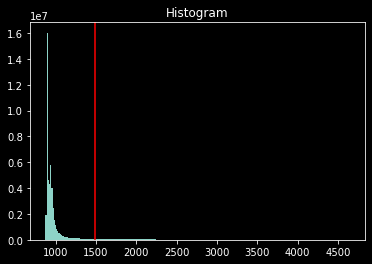

In [7]:
from skimage.filters import threshold_otsu, threshold_yen

thresh_otsu = threshold_otsu(crop_stack_gauss)
binary_stack = crop_stack_gauss > thresh_otsu

plt.hist(crop_stack_gauss.ravel(), bins=256)
plt.title('Histogram')
plt.axvline(thresh_otsu, color='r')
viewer.add_image(binary_stack)

In [8]:
binary_stack_filled = ndi.binary_fill_holes(binary_stack)
wo.image_stack_viewer(binary_stack_filled)

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=0), IntSlider(value=0, description='st…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_4D(stack_idx_1, stack_idx_2)>

(1, 140, 608, 608)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(-0.5, 607.5, 607.5, -0.5)

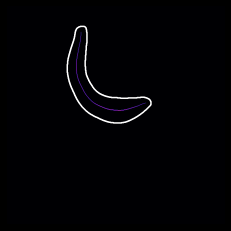

In [9]:
from skimage.morphology import medial_axis
print(binary_stack_filled.shape)
binary_stack_filled3d = np.squeeze(binary_stack_filled)
skel, distance = medial_axis(binary_stack_filled3d[1], return_distance=True)
# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel
print(dist_on_skel)
plt.imshow(dist_on_skel, cmap='magma')
plt.contour(binary_stack_filled3d[1], [0.5], colors='w')
plt.axis('off')

In [10]:
# perform skeletonization
skeleton =np.array([skeletonize(binary_stack_filled3d[i]) for i in range(binary_stack_filled3d.shape[0])])
print(skeleton.shape)
viewer.add_image(skeleton, colormap='magenta', blending='additive')

(140, 608, 608)


<Image layer 'skeleton' at 0x263b8a1b8e0>

In [11]:
from skan import Skeleton
sk_skeleton =[Skeleton(skeleton[i]) for i in range(skeleton.shape[0])]

In [12]:
print((sk_skeleton[1].coordinates))
print(sk_skeleton[10].path_lengths())
print(sk_skeleton[10].distances)

[[  0.   0.]
 [ 69. 209.]
 [ 70. 208.]
 [ 71. 208.]
 [ 72. 208.]
 [ 73. 208.]
 [ 74. 207.]
 [ 75. 207.]
 [ 76. 207.]
 [ 77. 207.]
 [ 78. 207.]
 [ 79. 207.]
 [ 80. 207.]
 [ 81. 206.]
 [ 82. 206.]
 [ 83. 206.]
 [ 84. 206.]
 [ 85. 206.]
 [ 86. 206.]
 [ 87. 206.]
 [ 88. 205.]
 [ 89. 205.]
 [ 90. 205.]
 [ 91. 205.]
 [ 92. 205.]
 [ 93. 205.]
 [ 94. 204.]
 [ 95. 204.]
 [ 96. 204.]
 [ 97. 204.]
 [ 98. 204.]
 [ 99. 204.]
 [100. 204.]
 [101. 204.]
 [102. 204.]
 [103. 204.]
 [104. 204.]
 [105. 204.]
 [106. 203.]
 [107. 203.]
 [108. 203.]
 [109. 202.]
 [110. 202.]
 [111. 202.]
 [112. 202.]
 [113. 202.]
 [114. 202.]
 [115. 202.]
 [116. 202.]
 [117. 201.]
 [118. 201.]
 [119. 201.]
 [120. 200.]
 [121. 200.]
 [122. 200.]
 [123. 200.]
 [124. 200.]
 [125. 200.]
 [126. 200.]
 [127. 199.]
 [128. 199.]
 [129. 199.]
 [130. 199.]
 [131. 199.]
 [132. 198.]
 [133. 198.]
 [134. 198.]
 [135. 198.]
 [136. 198.]
 [137. 197.]
 [138. 197.]
 [139. 197.]
 [140. 197.]
 [141. 197.]
 [142. 197.]
 [143. 197.]
 [144. 197.]

In [188]:
a = [ sk_skeleton[i].coordinates[sk_skeleton[i].degrees == 1] for i in range(len(sk_skeleton))]


In [352]:
# Finding the points where we have start/ends
end_points =[]
for k in range(len(sk_skeleton)):
    for i, val in enumerate(sk_skeleton[k].coordinates[sk_skeleton[k].degrees == 1]):
      end_points.append([k,val[0],val[1]])

np_endPoint = np.array(end_points)
print(np_endPoint.shape)
viewer.add_points(np_endPoint, face_color='cornflowerblue')


(462, 3)


In [132]:
i=0
coords = sk_skeleton[i].coordinates
length = sk_skeleton[i].path_lengths()
print(np.array(coords).shape)
# coord_test = np.zeros((coords.shape[0],4,))
# print(coord_test)
coord_test[:,0:] = coords
print(coord_test.shape)
print(coord_test[1])
# print(coords[::10])
# print(int(length/5))
# print(type(length.astype(int)))
# select_coords = sk_skeleton[i].coordinates  #ignore the first and last points
# print(select_coords.shape)
# print(select_coords[1,:])
# x = []
# select_coords = select_coords[np.newaxis,:,:]
# select_coords[i,:,:] = select_coords[1,:]
# x = np.array(x)
# print(x.shape)
# for k in range(len(sk_skeleton)):
#     x = sk_skeleton[k].coordinates[1:-2:70]
#     print(x)


(349, 2)
(349, 349, 2)
[[  0.   0.]
 [ 69. 209.]
 [ 70. 208.]
 [ 71. 208.]
 [ 72. 208.]
 [ 73. 208.]
 [ 74. 207.]
 [ 75. 207.]
 [ 76. 207.]
 [ 77. 207.]
 [ 78. 207.]
 [ 79. 207.]
 [ 80. 207.]
 [ 81. 206.]
 [ 82. 206.]
 [ 83. 206.]
 [ 84. 206.]
 [ 85. 206.]
 [ 86. 206.]
 [ 87. 206.]
 [ 88. 205.]
 [ 89. 205.]
 [ 90. 205.]
 [ 91. 205.]
 [ 92. 205.]
 [ 93. 205.]
 [ 94. 205.]
 [ 95. 204.]
 [ 96. 204.]
 [ 97. 204.]
 [ 98. 204.]
 [ 99. 204.]
 [100. 204.]
 [101. 204.]
 [102. 204.]
 [103. 204.]
 [104. 204.]
 [105. 204.]
 [106. 203.]
 [107. 203.]
 [108. 203.]
 [109. 203.]
 [110. 202.]
 [111. 202.]
 [112. 202.]
 [113. 202.]
 [114. 202.]
 [115. 202.]
 [116. 202.]
 [117. 201.]
 [118. 201.]
 [119. 201.]
 [120. 201.]
 [121. 200.]
 [122. 200.]
 [123. 200.]
 [124. 200.]
 [125. 200.]
 [126. 200.]
 [127. 200.]
 [128. 199.]
 [129. 199.]
 [130. 199.]
 [131. 199.]
 [132. 199.]
 [133. 199.]
 [134. 198.]
 [135. 198.]
 [136. 198.]
 [137. 197.]
 [138. 197.]
 [139. 197.]
 [140. 197.]
 [141. 197.]
 [142. 197.]
 [

In [13]:
#Borrwing from WormPose
# https://github.com/iteal/wormpose/blob/main/wormpose/pose/centerline.py
from scipy.interpolate import interp1d
def interpolate_skeleton(skeleton: np.ndarray, new_dims: int) -> np.ndarray:
    """
    Interpolates a worm skeleton to have a different number of points
    Modify to accept a 4x

    """
    new_pos_dim = []
    for dim in range(skeleton.shape[1]):
        y = skeleton[:, dim]
        x = np.arange(y.size)
        if np.any(np.isnan(y)):
            new_pos_dim.append([np.nan] * (new_dims + 1))
        else:
            # Interpolate the data using a cubic spline to "new_length" samples
            new_length = new_dims + 1
            new_x = np.linspace(x.min(), x.max(), new_length)
            new_y = interp1d(x, y, kind="cubic")(new_x)
            new_pos_dim.append(new_y)
    new_pos = np.vstack(new_pos_dim).T
    return new_pos

In [261]:
select_coords =[]
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,5)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
select_coords=np.array(select_coords)
viewer.add_points(select_coords, face_color='cornflowerblue')

<Points layer 'select_coords [1]' at 0x26454725ee0>

In [263]:
print(select_coords.shape)
select_coords[0]

(840, 3)


array([  0.,  69., 209.])

In [458]:
"""
Refresh on vector calc
https://stackoverflow.com/questions/7469959/given-2-points-how-do-i-draw-a-line-at-a-right-angle-to-the-line-formed-by-the-t/7470098#7470098
The matrix representation of 2D transformation:
x' = xcos(t) - ysin(t)
y' = xsin(t)  - ycost(t)

so if t =90 deg then 
x'=-y
y'= x

then normals to line segment would be:
(-dy,dx)(dy,-dx)

"""
width = 100
skel_perp = np.empty((2,), dtype=np.float32)

perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
# Take the magnitude to get the length of the vector 
norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

skel_perp[0] = (perp_line[0] / norm) * (width / 2)
skel_perp[1] = (perp_line[1] / norm) * (width / 2)

##Box origin is 'lower' instead of upper
bot_l = coord_a + skel_perp
top_l = coord_b + skel_perp
top_r = coord_b - skel_perp # 
bot_r = coord_a - skel_perp # 

bbox_rect = np.array(
    [bot_l, top_l, top_r, bot_r]
)


In [470]:
#Plotting left and right boxes
width = 50
skel_perp = np.empty((2,), dtype=np.float32)

perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
# Take the magnitude to get the length of the vector 
norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

#Normal to skeleton
skel_perp[0] = (perp_line[0] / norm) * (width / 2)
skel_perp[1] = (perp_line[1] / norm) * (width / 2)
# skel_perp[1] = (perp_line[1] / norm) 

##Box origin is 'lower' instead of upper
bot_l = coord_a + skel_perp
top_l = coord_b + skel_perp
top_r = coord_b - skel_perp # 
bot_r = coord_a - skel_perp # 

bbox_rect_left = np.array(
    [coord_a, coord_b, top_l, bot_l]
)

bbox_rect_right = np.array(
    [coord_a, coord_b, top_r, bot_r]
)

In [610]:
#Make the skeleton Points
select_coords =[]
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,50)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
select_coords=np.array(select_coords)
viewer.add_points(select_coords, face_color='cornflowerblue')

<Points layer 'select_coords [1]' at 0x1242f4a2df0>

In [285]:
def create_skeleton_box(coord_a,coord_b,side,width='100'):
    """
    
    Refresh on vector calc
    https://stackoverflow.com/questions/7469959/given-2-points-how-do-i-draw-a-line-at-a-right-angle-to-the-line-formed-by-the-t/7470098#7470098
    The matrix representation of 2D transformation:
    x' = xcos(t) - ysin(t)
    y' = xsin(t)  - ycost(t)

    so if t =90 deg then 
    x'=-y
    y'= x

    then normals to line segment would be:
    (-dy,dx)(dy,-dx)

    """
    width = 100
    skeleton_norm = np.empty((2,), dtype=np.float32)

    perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
    # Take the magnitude to get the length of the vector 
    norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

    skeleton_norm[0] = (perp_line[0] / norm) * (width / 2)
    skeleton_norm[1] = (perp_line[1] / norm) * (width / 2)

    ##Box origin is 'lower' instead of upper
    bot_l = coord_a + skeleton_norm
    top_l = coord_b + skeleton_norm
    top_r = coord_b - skeleton_norm # 
    bot_r = coord_a - skeleton_norm # 

    if side == 'L':
        bbox_rect_left = np.array(
            [coord_a, coord_b, top_l, bot_l]
        )
        return bbox_rect_left
    elif side == 'R':
        bbox_rect_right = np.array(
            [coord_a, coord_b, top_r, bot_r]
        )
        return bbox_rect_right
    elif side == 'LR':
        bbox_rect_left =[coord_a, coord_b, top_l, bot_l]
        bbox_rect_right =[coord_a, coord_b, top_r, bot_r]
        return np.array([bbox_rect_left, bbox_rect_right])
    else: 
        bbox_rect = np.array(
            [bot_l, top_l, top_r, bot_r]
        )
        return bbox_rect



In [143]:
k=0
coords =sk_skeleton[k].path_coordinates(0)
interp_coord = interpolate_skeleton(coords,5)

In [337]:
a = np.array([[1,1,1,1],[1 ,2 ,4 ,5]])
print(a)
print(a.shape)

[[1 1 1 1]
 [1 2 4 5]]
(2, 4)


In [281]:
# #need interpolation to be in a n, 4,2
# print(coords.shape)
# print(interp_coord)
# print(interp_coord.shape)
# print(interp_coord.shape[0])
# print(interp_coord.shape[1])
# box_test = np.zeros((1,len(sk_skeleton),interp_coord.shape[0],4))
# for k in range(len(sk_skeleton)):
#     coords =sk_skeleton[k].path_coordinates(0)
#     interp_coord = interpolate_skeleton(coords,5)
#     for i in range(interp_coord.shape[0]):
#         box_test[0,k,i,:]= [0,k, interp_coord[i,0], interp_coord[i,1]]
# print(box_test)

# print(box_test.shape)
# box_test[0,:].shape
# viewer.add_points(box_test[0,:])


In [334]:
i=0
left_box, right_box  = create_skeleton_box(interp_coord[i], interp_coord[i+1],side='LR',width=50)
a = np.array([left_box , right_box])
print(a)
print(left_box.shape)
z = np.zeros((4,2))
left_box = np.hstack((z,left_box))
left_box[:,1]= 1
print(z)
print(left_box.shape)
print(left_box)

[[[ 69.         209.        ]
  [137.8        197.01114666]
  [146.3834837  246.26887524]
  [ 77.5834837  258.25772858]]

 [[ 69.         209.        ]
  [137.8        197.01114666]
  [129.2165163  147.75341808]
  [ 60.4165163  159.74227142]]]
(4, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(4, 4)
[[  0.           1.          69.         209.        ]
 [  0.           1.         137.8        197.01114666]
 [  0.           1.         146.3834837  246.26887524]
 [  0.           1.          77.5834837  258.25772858]]


In [44]:
k=0
layer_boxes = []
coords =sk_skeleton[k].path_coordinates(0)
interp_coord = interpolate_skeleton(coords,50)
for i in range(interp_coord.shape[0]-1):
    left_box, right_box  = create_skeleton_box(interp_coord[i], interp_coord[i+1],side='LR',width=50)
    layer_boxes.append([left_box , right_box])
layer_boxes = np.array(layer_boxes)
print(layer_boxes.shape)

# viewer.add_shapes(layer_boxes[1,0]  ,edge_color='blue')


(50, 2, 4, 2)


In [45]:
##Plot the L and R boxes
viewer.add_shapes(layer_boxes[:,0,:,:]  ,face_color='blue') # Left boxes
viewer.add_shapes(layer_boxes[:,1,:,:]  ,face_color='red') # Right boxes

<Shapes layer 'Shapes [1]' at 0x263aea75850>

In [46]:
interp_coord.shape[0]

51

In [311]:
c_num = 1
left_box, right_box  = create_skeleton_box(interp_coord[c_num], interp_coord[c_num+1],side='LR',width=50)
print(left_box)
left_box.shape

[[137.8        197.01114666]
 [206.6        199.11191896]
 [205.07398722 249.08862641]
 [136.27398722 246.98785412]]


(4, 2)

In [349]:
##Combining both coordinate interpolation with boxes
select_coords =[]
layer_boxes = []
n_interpol = 15
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,n_interpol)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
        if c_num<(interp_coord.shape[0]-1):
            left_box, right_box  = create_skeleton_box(interp_coord[c_num], interp_coord[c_num+1],side='LR',width=50)
            two_column = np.zeros((4,2))
            left_box = np.hstack((two_column,left_box))
            right_box = np.hstack((two_column,right_box))
            left_box[:,1]= k
            right_box[:,1]=k
            layer_boxes.append([left_box , right_box])
select_coords=np.array(select_coords)
layer_boxes = np.array(layer_boxes)
#Plot skeleton interpolation points
viewer.add_points(select_coords, face_color='cornflowerblue')
##Plot the L and R boxes
viewer.add_shapes(layer_boxes[:,0]  ,face_color='blue') # Left boxes
viewer.add_shapes(layer_boxes[:,1],face_color='red') # Right boxes


<Shapes layer 'Shapes [1]' at 0x264528e1640>

In [471]:
viewer.add_shapes(
    bbox_rect_left,
    name='bounding box',
    face_color ='blue'
)
viewer.add_shapes(
    bbox_rect_right,
    name='bounding box',
    face_color='red'
)

<Shapes layer 'bounding box [3]' at 0x12392eff8b0>

In [485]:
min_val = bbox_rect_right.min(axis=0)
max_val = bbox_rect_right.max(axis=0)
tl = np.array([min_val[0], min_val[1]])
br = np.array([max_val[0], max_val[1]])
box = np.round(np.array([tl, br])).astype(int)

In [505]:
# import analysis_utils as au

img = crop_stack[:,:,box[0,0]:box[1,0],box[0,1]:box[1,1]]
roi_mean = img.mean()
roi_max = img.max()
print(roi_mean.compute(),roi_max.compute())

1248.9526542324247 4304


In [301]:
## Example to show how shapes are stored
a =np.array(viewer.layers['Shapes [2]'].data)
print(a.shape)
print(a)

(4, 4, 4)
[[[  0.           0.         364.64465881 111.97549114]
  [  0.           0.         364.64465881 294.03483038]
  [  0.           0.         484.15600421 294.03483038]
  [  0.           0.         484.15600421 111.97549114]]

 [[  0.           0.         160.24675033 424.7154604 ]
  [  0.           0.         160.24675033 527.47287887]
  [  0.           0.         248.4840988  527.47287887]
  [  0.           0.         248.4840988  424.7154604 ]]

 [[  0.          18.         481.92214729  81.81842267]
  [  0.          18.         481.92214729 161.12034345]
  [  0.          18.         538.88549883 161.12034345]
  [  0.          18.         538.88549883  81.81842267]]

 [[  0.          18.         423.84186728 227.01912268]
  [  0.          18.         423.84186728 372.2198227 ]
  [  0.          18.         468.51900575 372.2198227 ]
  [  0.          18.         468.51900575 227.01912268]]]


### PLAYGROUND

In [ ]:
## Attempt to get the coordinates of the skeleton however they are already sorted so only way to do this is with interpolation
# select_coords =[]
# path_length = []
# id =[]
# for k in range(len(sk_skeleton)):
#     length = sk_skeleton[k].path_lengths()
#     # path_length.append(length)
#     for index,item in enumerate(sk_skeleton[k].coordinates):
#         if index%(int(length[0]/5)) ==0:
#             # id.append(index)
#             select_coords.append([k,item[0],item[1]])
# # select_coords = np.array(select_coords)
# print(id)
# print(path_length)

In [ ]:
from skan import summarize
#Attempting to plot multiple points in skeleton
i=0
branch = summarize(sk_skeleton[i])
branch.head()
img_t =crop_stack[:,0,:,:]
img_t =np.squeeze(img_t)
# branch.hist(column='branch-distance', by='branch-type', bins=100);
draw.overlay_euclidean_skeleton_2d(img_t, branch,
                                   skeleton_color_source='branch-type');

In [ ]:
from scipy.ndimage import distance_transform_edt
sk_skeleton[0].coo
distance_transform_edt()

In [402]:
binary_stack_filled_1=np.squeeze(binary_stack_filled)
print(binary_stack_filled_1.shape)

(200, 608, 608)


In [416]:
from skimage.measure import label, regionprops_table

properties = regionprops_table(
    binary_stack_filled_1[0].astype(np.uint8), properties=('label', 'bbox', 'perimeter', 'area')
)

#Addinc circularity to the table
properties['circularity'] = circularity(
    properties['perimeter'], properties['area']
)

bbox_rects = make_bbox([properties[f'bbox-{i}'] for i in range(4)])

# specify the display parameters for the text
text_parameters = {
    'string': 'label: {label}\ncirc: {circularity:.2f}',
    'size': 12,
    'color': 'green',
    'anchor': 'upper_left',
    'translation': [-3, 0],
}

shapes_layer = viewer.add_shapes(
    bbox_rects,
    face_color='transparent',
    edge_color='green',
    properties=properties,
    text=text_parameters,
    name='bounding box',
)

In [414]:
def make_bbox(coord_a,coord_b,width):
    """Get the coordinates of the corners of a
    bounding box from the extents

    Parameters
    ----------
    bbox_extents : list (4xN)
        List of the extents of the bounding boxes for each of the N regions.
        Should be ordered: [min_row, min_column, max_row, max_column]

    Returns
    -------
    bbox_rect : np.ndarray
        The corners of the bounding box. Can be input directly into a
        napari Shapes layer.
    """
    # preallocates some internal data structures
    skel_perp = np.empty((2,), dtype=np.float32)

    perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
    norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

    skel_perp[0] = (perp_line[0] / norm) * (width / 2)
    skel_perp[1] = (perp_line[1] / norm) * (width / 2)

    minr = coord_a + skel_perp
    minc = coord_b + skel_perp
    maxr = coord_b - skel_perp
    maxc = coord_a - skel_perp

    bbox_rect = np.array(
        [[minr, minc], [maxr, minc], [maxr, maxc], [minr, maxc]]
    )
    bbox_rect = np.moveaxis(bbox_rect, 2, 0)

    return bbox_rect

In [391]:
viewer.add_points(select_coords, face_color='cornflowerblue')

<Points layer 'select_coords' at 0x12431f1b910>

In [386]:
import pims
import trackpy as tp

In [ ]:
features = tp.locate(np_stack[12], diameter=(7,7,7), threshold =84,minmass=11000, separation= (3,1,1))
print('Features found: {0}'.format(len(features)))
tp.subpx_bias(features)
print('Features found: {0}'.format(len(features)))
features.head()

In [ ]:
test =tp.annotate3d(features,np_stack[1],color=None)
test3 =np.array(test[:,np.newaxis,:,:,:])
test3 = np.swapaxes(test3,1,4)
test3 = np.squeeze(test3)

wo.image_stack_viewer(np.clip(test3,0,0.5),colormap='viridis')

In [ ]:
volume = tp.batch(np_stack, diameter=(7,7,7), threshold =84,minmass=11000, separation= (3,1,1))


In [ ]:
linked = tp.link_df(volume, 2.5, pos_columns=['xum', 'yum', 'zum'])
msd3D = tp.emsd(linked, mpp=1, fps=40, max_lagtime=20,
                pos_columns=['xum', 'yum', 'zum'])
ax = msd3D.plot(style='o', label='MSD in 3D')
ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
ax.set_xlabel('lag time $t$')
# ax.set_xlim(0, 16)
# ax.set_ylim(0, 20)
ax.legend(loc='upper left');

<Image layer 'dask_raw_ds [1]' at 0x12432fa3760>

In [ ]:
data = linked.loc[:,['particle','frame','z','y','x']]
data = data.dropna(axis=0)
data= data.to_numpy()
print(data)

properties = linked.loc[:,['mass', 'size_z', 'size_y', 'size_x','signal','raw_mass','ep_z','ep_y','ep_x']]

In [ ]:
viewer.add_points(data[:,1:], size=1,name='particles',face_color='white',
edge_color= '#ff55ff', scale=[1,z_scale,1,1])

In [ ]:
viewer.add_tracks(data, scale=[z_scale,1,1])